In [47]:
import requests
import json
from time import sleep
import igraph as ig

In [2]:
# setup api secrets
with open('../secrets/tiktok.json') as f:
    secrets = json.load(f)
    
client_key = secrets['client_key']
client_secret = secrets['client_secret']

# get access token
url = "https://open.tiktokapis.com/v2/oauth/token/"
headers = {
    "Content-Type": "application/x-www-form-urlencoded",
    "Cache-Control": "no-cache"
}
data = {
    "client_key": client_key,
    "client_secret": client_secret,
    "grant_type": "client_credentials"
}
response = requests.post(url, headers=headers, data=data)
response_json = response.json()
access_token = response_json['access_token']

In [3]:
with open('../data/hashtags/stitch/vertices/sources/jazz.json') as f:
    vertices = json.load(f)

In [4]:
def request_followers(username, cursor=None, retries=3):
    url = 'https://open.tiktokapis.com/v2/research/user/followers/'
    headers = {
        "authorization": f"bearer {access_token}"
    }
    data = {
        'username': username,
        'max_count': 100
    }

    if cursor:
        data['cursor'] = cursor

    attempt = 0
    while attempt < retries:
        response = requests.post(url, headers=headers, json=data, timeout=30)
        
        if response.status_code == 504:
            attempt += 1
            print(f"Error 504, retrying... attempt {attempt}")
            time.sleep(5)
        elif response.status_code != 200:
            raise Exception(f"Error: {response.status_code} - {response.text}")
        else:
            return response.json()
    
    raise Exception(f"Error 504 - Max retries exceeded for {username}")


def request_followers_full(username, sleep_delay=2):
    response = request_followers(username)
    user_followers = response['data']['user_followers']

    while response['data']['has_more']:
        sleep(sleep_delay)

        cursor = response['data']['cursor']
        response = request_followers(username, cursor=cursor)
        user_followers += response['data']['user_followers']

        print(cursor)

    return user_followers

In [64]:
def request_following(username, cursor=None, retries=3):
    url = 'https://open.tiktokapis.com/v2/research/user/following/'
    headers = {
        "authorization": f"bearer {access_token}"
    }
    data = {
        'username': username,
        'max_count': 100
    }

    if cursor:
        data['cursor'] = cursor

    attempt = 0
    while attempt < retries:
        response = requests.post(url, headers=headers, json=data, timeout=30)
        
        if response.status_code == 504:
            attempt += 1
            print(f"Error 504, retrying... attempt {attempt}")
            time.sleep(5)
        elif response.status_code != 200:
            raise Exception(f"Error: {response.status_code} - {response.text}")
        else:
            return response.json()
    
    raise Exception(f"Error 504 - Max retries exceeded for {username}")


def request_following_full(username, sleep_delay=2):
    response = request_following(username)
    user_following = response['data']['user_following']

    while response['data']['has_more']:
        sleep(sleep_delay)

        cursor = response['data']['cursor']
        response = request_following(username, cursor=cursor)
        user_following += response['data']['user_following']

    return user_following

In [40]:
for v in vertices[15:]:
    username = v['username']
    followers = request_followers_full(username)
    v['followers'] = followers

1719785081
1719710758
1719259803
1718903849
1716264189
1716051832
1715956059
1714160529
1713980998
1713931825
1713899553
1713859546
1713835806
1713799468
1713753300
1713736382
1713722863
1713711970
1713696085
1713675920
1713655280
1713644931
1713637044
1713631716
1713626973
1713617017
1712930410
1712842403
1712729305
1699124622
1671893461
1619849370
1725959009
1725948230
1725939995
1725931053
1725921049
1725913042
1725902422
1725894785
1725886233
1725873808
1725855367
1725843435
1725805206
1725752833
1725695598
1725639828
1725580215
1725538268
1725492317
1725450939
1725404737
1725368824
1725328803
1725295700
1725252990
1725222307
1725192170
1725157562
1725132500
1725107575
1725076768
1725052263
1725023041
1724991336
1724970444
1724949212
1724930068
1724906806
1724890768
1724875097
1724855668
1724838586
1724821150
1724807172
1724796053
1724784211
1724769048
1724748320
1724724591


In [69]:
for v in vertices:
    try:
        username = v['username']
        following = request_following_full(username, sleep_delay=0)
        v['following'] = following
    except Exception:
        continue

{'data': {'has_more': True, 'user_following': [{'display_name': 'TransformersOfficial', 'username': 'transformersofficial'}, {'display_name': 'Comedian_MarcellusC', 'username': 'marcellus.the.hairless'}, {'username': 'thevalaverse', 'display_name': 'Valaverse'}, {'display_name': 'Dadjokesarefun', 'username': 'dadjokesarefunright'}, {'display_name': 'fatmancomics', 'username': 'fatmancomics'}, {'username': 'primedynamix', 'display_name': 'Prime Dynamixx'}, {'display_name': 'Hero In Training', 'username': 'herointraining_'}, {'display_name': 'Gill Iburn', 'username': 'mrgilliburn'}, {'display_name': 'Colin Pomeroy', 'username': 'colinpomeroyyy'}, {'display_name': 'TYPE 2A/100B', 'username': 'caesaraltaid_'}, {'display_name': 'nerdy_live', 'username': 'nerdy_live'}, {'display_name': 'Toy Dungeon', 'username': 'toy_dungeon'}, {'username': 'jokinglytimeless1994', 'display_name': 'pop culture, anime, cosplay'}, {'display_name': 'StarTalk', 'username': 'neildegrassetyson'}, {'username': 'juan

In [100]:
edge_list = [(s['username'], t['username']) for s in vertices for t in v['following'] if 'following' in v.keys()]

In [101]:
len(edge_list)

1071

In [82]:
g = ig.Graph.TupleList(edge_list, directed=True)

In [85]:
nodes = set()
for j,k in edge_list:
    nodes.add(j)
    nodes.add(k)

In [95]:
len(edge_list)

1071

In [94]:
len(g.es)

1071

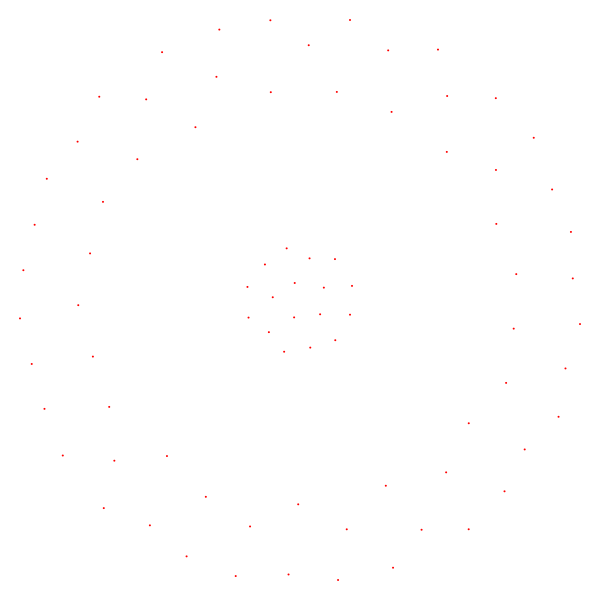

In [83]:
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, vertex_size=2, vertex_label=None, vertex_frame_width=0, 
            edge_arrow_size=0, edge_width=0.02,)

In [81]:
edge_list

[('art2squared', 'adrianvalia'),
 ('art2squared', 'romerolubambo'),
 ('art2squared', 'cbabibayoc24'),
 ('art2squared', 'sarahhanahan'),
 ('art2squared', 'itsnotaxylophone'),
 ('art2squared', 'rachel_morgan23'),
 ('art2squared', 'lgoldings'),
 ('art2squared', 'joshwalshmusic'),
 ('art2squared', 'bebenans01'),
 ('art2squared', 'oldmanwoods'),
 ('art2squared', 'carlallen1961'),
 ('art2squared', 'theroycemartin'),
 ('art2squared', 'sullivanfortner'),
 ('art2squared', 'warrenwolf'),
 ('art2squared', 'ronsmithdrums'),
 ('art2squared', 'girlconductor'),
 ('art2squared', 'roncarterjazz'),
 ('art2squared', 'mackavenuerecords'),
 ('art2squared', '_jaysenior'),
 ('art2squared', 'drumeoofficial'),
 ('art2squared', 'joshie_allon'),
 ('art2squared', 'bluenotenyc'),
 ('art2squared', 'antoniodrums_1'),
 ('art2squared', 'joshjacobsongs'),
 ('art2squared', 'ryanrhodes_official'),
 ('art2squared', 'gregoryhutchinsonmusic'),
 ('art2squared', 'lou.aye2'),
 ('art2squared', 'internationaljazzday'),
 ('art2sq

In [92]:
len(vertices[3]['following'])

2587